In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import statsmodels.api as sm
from scipy import  stats
import pywt
import copy
from statsmodels.tsa.arima_model import ARMA
from numpy.linalg import LinAlgError

D:\Software\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_HS300 = pd.read_csv('df_000300.csv', header=0, index_col=0, encoding='utf-8')
df_ZZ500 = pd.read_csv('df_000905.csv', header=0, index_col=0, encoding='utf-8')

In [3]:
start_day = '2010-01-04'
end_day = '2010-12-31'
test = df_HS300.loc[start_day:end_day,:]
test = test['CLOSE'] 
StockDate = df_HS300.loc[start_day:'2011-01-20',:]
Close_original = StockDate['CLOSE']

In [4]:
% matplotlib inline

In [10]:
def wt(index_list,data,wavefunc='db4',lv=4,m=1,n=4):   # 打包为函数，方便调节参数。  lv为分解层数；data为最后保存的dataframe便于作图；index_list为待处理序列；wavefunc为选取的小波函数；m,n则选择了进行阈值处理的小波系数层数
   
    # 分解
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   # 按 level 层分解，使用pywt包进行计算， cAn是尺度系数 cDn为小波系数

    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn函数

    # 去噪过程
    for i in range(m,n+1):   # 选取小波系数层数为 m~n层，尺度系数不需要处理
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # 计算阈值
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # 向零收缩
            else:
                coeff[i][j] = 0   # 低于阈值置零b

    # 重构
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
            
    denoised_index = np.sum(coeff, axis=0)   

    # 在原dataframe中添加处理后的列便于画图
    data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})

    # 画图
    data.plot(figsize=(10,10),subplots=(2,1))
    data.plot(figsize=(10,5))
    # 调用函数wt
    return coeff

# print('原始价格序列长度：%d'%len(test))
# for i in range(len(coeff)):
#     if i == 0:
#         print('\n尺度序列长度：%d'%len(coeff[i]))
#     else:
#         print('\n细节序列[%.0f]的长度：%d'%(i, len(coeff[i])))


In [6]:
data = pd.DataFrame()

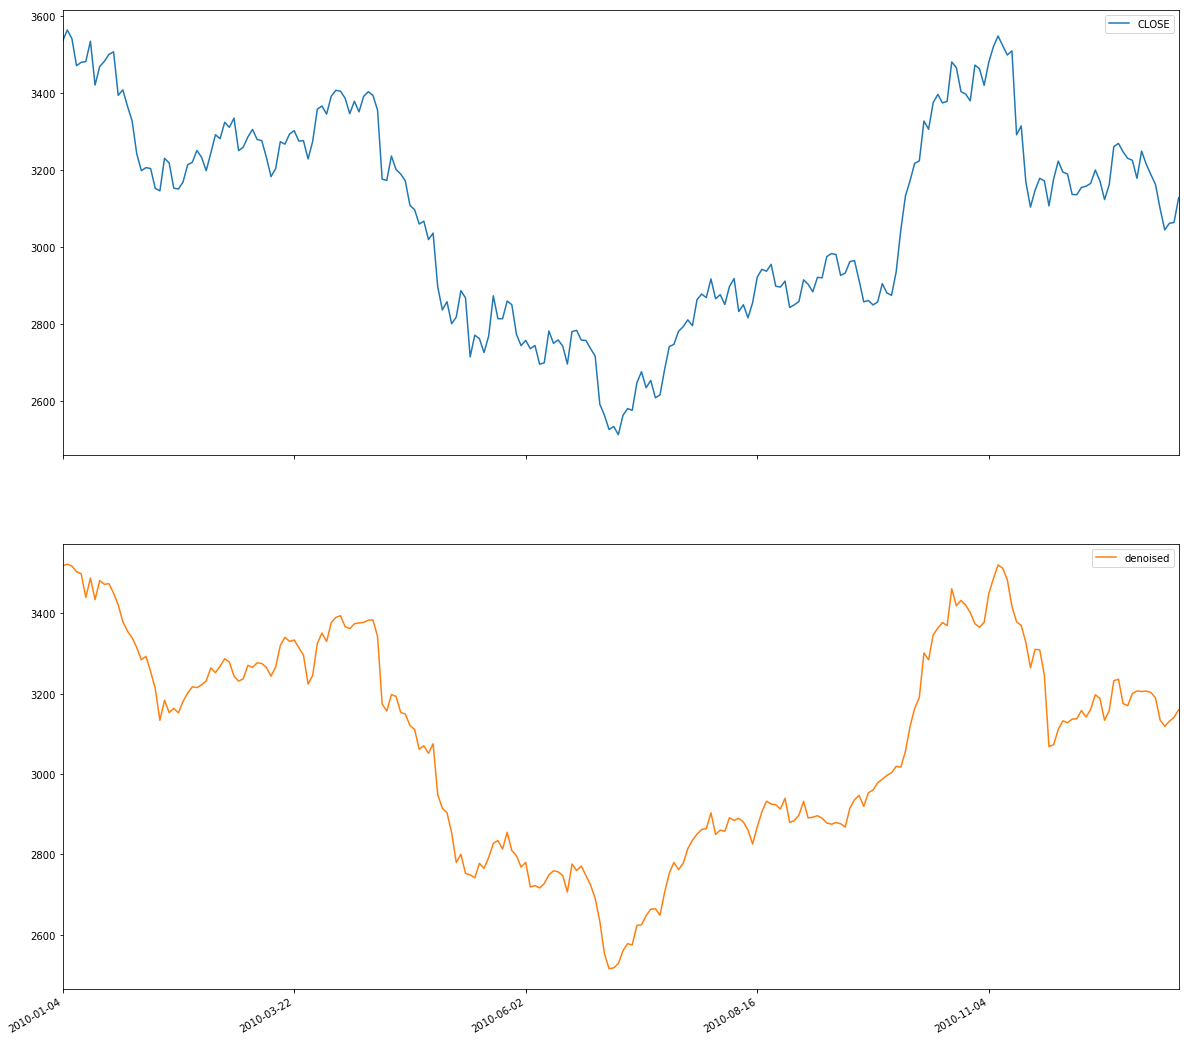

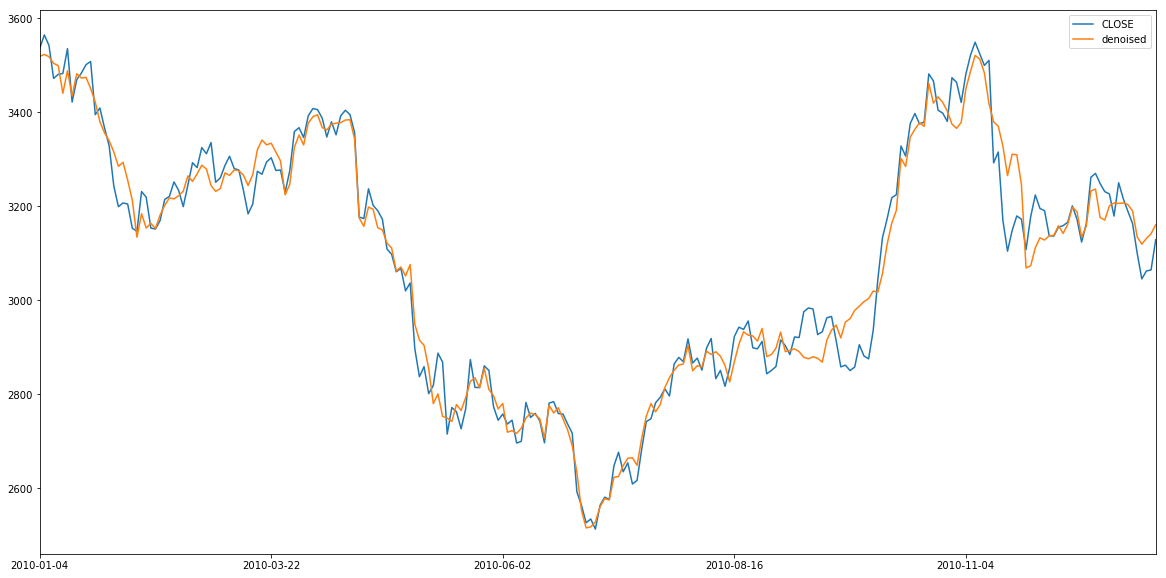

In [11]:
coeff = wt(test, data)

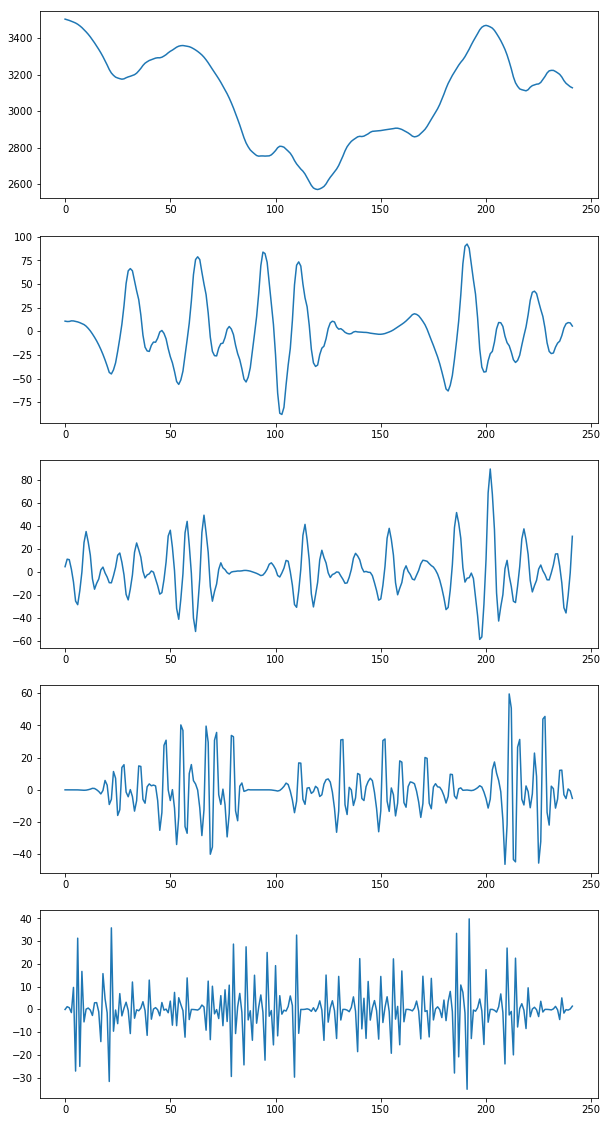

In [18]:
fig, ax =  plt.subplots(len(coeff), 1, figsize=(10, 20))
for i in range(len(coeff)):
    ax[i].plot(coeff[i])

In [21]:
from statsmodels.tsa.stattools import adfuller

In [23]:
for i in range(1, len(coeff)):
    dftest = adfuller(coeff[i], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value(%s)' % key] = value
    print(dfoutput)
    print('\n')

Test Statistic                  -5.226967
p-value                          0.000008
#Lags Used                      14.000000
Number of observations Used    227.000000
Critical value(1%)              -3.459490
Critical value(5%)              -2.874358
Critical value(10%)             -2.573602
dtype: float64


Test Statistic                -8.319843e+00
p-value                        3.597280e-13
#Lags Used                     1.400000e+01
Number of observations Used    2.270000e+02
Critical value(1%)            -3.459490e+00
Critical value(5%)            -2.874358e+00
Critical value(10%)           -2.573602e+00
dtype: float64


Test Statistic                -1.069859e+01
p-value                        3.571436e-19
#Lags Used                     1.500000e+01
Number of observations Used    2.260000e+02
Critical value(1%)            -3.459620e+00
Critical value(5%)            -2.874415e+00
Critical value(10%)           -2.573632e+00
dtype: float64


Test Statistic                -1.189342

In [36]:
import warnings
warnings.filterwarnings('ignore')

order = []
for i in range(1, len(coeff)):
    order.append(sm.tsa.arma_order_select_ic(coeff[i], ic='bic')['bic_min_order'])    

In [69]:
model, results = [], []
for i in range(1, len(coeff)):
    model.append(ARMA(coeff[i], order=order[i-1]))

In [70]:
for i in range(len(model)):
    new_order = list(order[i])
    while True:
        try:
            results.append(model[i].fit())
        except ValueError:
            new_order[1] = np.max((0, new_order[1]-1))
            model[i] = ARMA(coeff[i+1], order=new_order)
        if len(results)>= i+1:
            break

In [72]:
results

In [71]:
order

[(4, 1), (4, 2), (4, 2), (2, 2)]

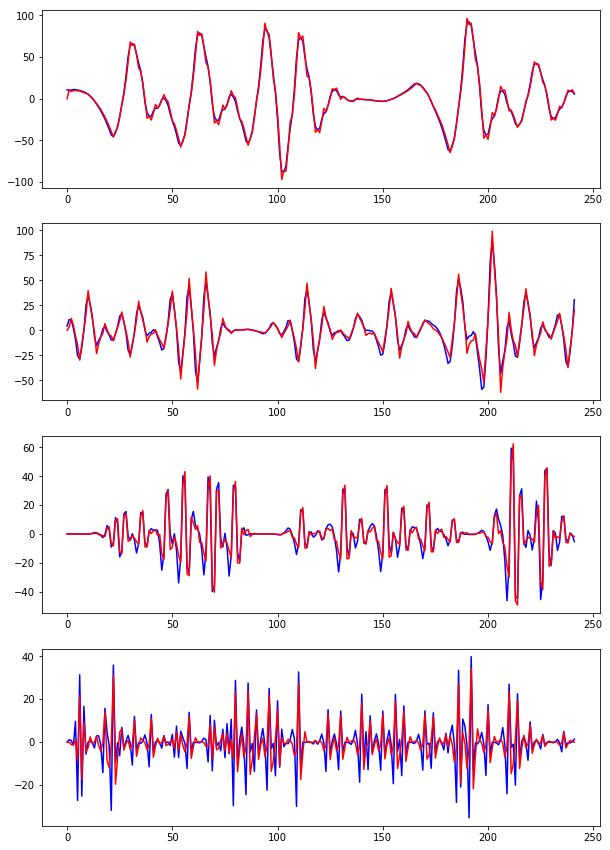

In [73]:
plt.figure(figsize=(10,15))
for i in range(len(results)):
    plt.subplot(len(results), 1, i+1)
    plt.plot(coeff[i+1], 'blue')
    plt.plot(results[i].fittedvalues,'red')

In [412]:
features = 5
interval = 0
X = []
Y = []
for i in range(len(coeff[0])):
    if i+features+interval < len(coeff[0]):
        X.append(coeff[0][i:i+features])
        Y.append(coeff[0][i+features+interval])
X =  np.array(X)
Y =  np.array(Y)

In [356]:
svr = svm.SVR(kernel='rbf', C=100, gamma=3)

In [357]:
svr1 = svr.fit(X,Y)

In [358]:
y = svr1.predict(X)

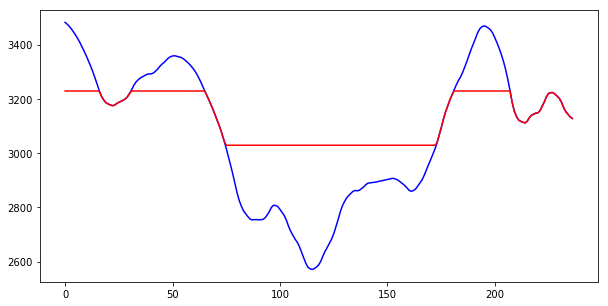

In [359]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(Y, 'blue')
plt.plot(y, 'red')

In [169]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor as GBR

In [171]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

In [460]:
gbr = GBR(learning_rate=0.1, n_estimators=100, max_depth=3)

In [461]:
y_gbr = gbr.fit(X, Y).predict(X)

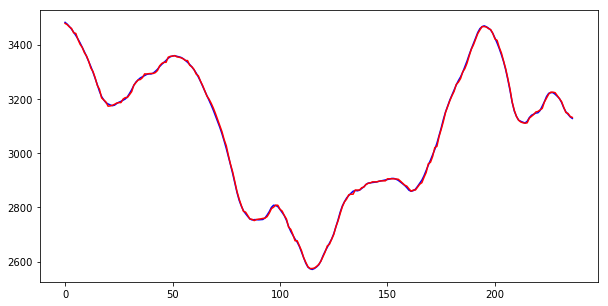

In [462]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(Y, 'blue')
plt.plot(y_gbr, 'red')

In [212]:
D_series = []
for i in range(len(results)):
    D_series.append(results[i].predict(len(test), len(Close_original)-1, dynamic=True))

In [213]:
D_series

[array([ 1.84270466, -1.24169664, -4.14046195, -6.43451102, -7.75727151,
        -8.13244121, -7.60480368, -6.27726014, -4.36850618, -2.14045008,
         0.139374  ,  2.21530037,  3.87398329]),
 array([ 48.76532244,  39.87535464,  17.41674646,  -9.24588719,
        -28.64474221, -34.91847786, -27.65337176, -11.61929754,
          6.01545148,  18.60971484,  22.41411807,  17.46224935,   6.95943326]),
 array([-2.27540485,  5.2119649 ,  3.95959809, -2.77913314, -3.09579004,
         0.84557882,  0.95409346, -0.51671573,  0.66069141,  1.08177833,
        -1.10634911, -1.51808755,  0.75475057]),
 array([ -1.43697972e+00,   7.18100809e-01,  -1.08665769e-02,
         -3.16102617e-01,   3.14432616e-01,  -1.46187099e-01,
          8.51484113e-04,   7.44703685e-02,  -6.42283967e-02,
          3.40835893e-02,   4.61620781e-03,  -1.29271108e-02,
          1.75346038e-02])]

In [444]:
X_ = copy.deepcopy(X)
Y_ = copy.deepcopy(Y)
for i in range(len(Close_original) - len(test)):
    X_ = np.concatenate((X_, np.array([np.concatenate((X_[-1][-features+1:], Y_[[-interval-1]]))])))
    Y_ = np.concatenate((Y_, gbr1.predict(X_[-1])))

In [463]:
X_ = copy.deepcopy(X)
Y_ = copy.deepcopy(Y)

In [299]:
np.sum(D_series, axis = 0)

array([ 46.89564253,  44.5637237 ,  17.22501602, -18.77563396,
       -39.18337115, -42.35152735, -34.3032305 , -18.33880304,
         2.24340831,  17.58512668,  21.45175917,  18.14653506,  11.60570173])

In [386]:
index_predict = Y_[len(test) - len(Close_original): ] + np.sum(D_series, axis = 0)

In [387]:
index_predict

array([ 3175.88679763,  3173.5548788 ,  3146.21617111,  3110.21552113,
        3089.80778395,  3086.63962775,  3094.6879246 ,  3110.65235206,
        3131.2345634 ,  3146.57628178,  3150.44291427,  3147.13769016,
        3140.59685683])

In [388]:
Y_[len(test) - len(Close_original): ]

array([ 3128.9911551,  3128.9911551,  3128.9911551,  3128.9911551,
        3128.9911551,  3128.9911551,  3128.9911551,  3128.9911551,
        3128.9911551,  3128.9911551,  3128.9911551,  3128.9911551,
        3128.9911551])

In [389]:
index_real = Close_original[len(test) - len(Close_original):].values
index_real

array([ 3189.682,  3175.662,  3159.643,  3166.624,  3108.187,  3124.922,
        3142.337,  3141.284,  3091.862,  2974.35 ,  2977.648,  3044.851,
        2944.713])

In [390]:
model_metrics_name = [explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]  # 回归评估指标对象集
model_metrics_list = []  # 回归评估指标列表
for m in model_metrics_name:  # 循环每个指标对象
    tmp_score = m(index_predict, index_real)  # 计算每个回归指标结果
    model_metrics_list.append(tmp_score)

In [391]:
model_metrics_list

[-8.3982063342140911,
 69.48032687666543,
 9113.2490208539421,
 -9.9093487801622313]

In [484]:
df = pd.DataFrame(np.array([model_metrics_list]), index=['model'], columns=['ev', 'mae', 'mse', 'r2'])

In [483]:
np.array([model_metrics_list])

array([[ -8.39820633e+00,   6.94803269e+01,   9.11324902e+03,
         -9.90934878e+00]])